In [316]:
# Import packages
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt
import skimage.measure

In [340]:
# Check data
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'
data_file = 'Fig3_ver01_221025_data119.cathodic.dF.dFF'
# 'Fig3_ver01_221025_data119.cathodic.dF.dFF'
# 'Fig3_ver05_221114_data099.cathodic.dF,dFF'
# 'Fig3_ver05_221114_data101.anodic.dF,dFF'
# 'Fig3_ver05_221114_data239.cathodic.dF,dFF'
# 'Fig3_ver05_221114_data240.anodic.dF,dFF'
# 'Fig3_ver07_221123_data099data119.ImgSig'

data_dir = os.path.join(base_dir, 'data')
fig_dir = os.path.join(data_dir, 'Fig3')
data_path = os.path.join(fig_dir, data_file)

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

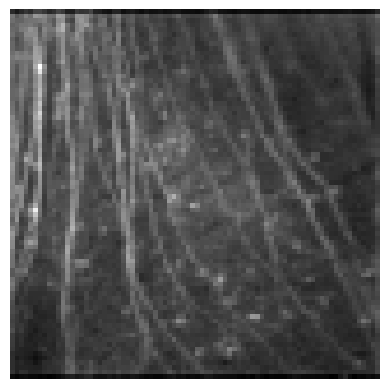

In [341]:
# Check the background image
background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
# 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'
# 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
# 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data101.anodic_picture.txt'
# 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data239.cathodic_picture.txt'
# 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data240.anodic_picture.txt'

img_data = []
with open(background_path) as file:
    for (i, line) in enumerate(file):
        row_data = np.expand_dims(np.array(line.split(',')[:-1]).astype('float64'), axis=0)
        if i == 0:
            img_data = row_data
        else:
            img_data = np.concatenate([img_data, row_data], axis=0)

plt.imshow(img_data, cmap='gray')
plt.axis('off')
plt.show()

In [342]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [344]:
# Print out shapes, min and max values
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    dF_var = 'data119_cathodic_dF'
    dFF_var = 'data119_cathodic_dFF'
elif data_file == 'Fig3_ver07_221123_data099data119.ImgSig':
    dF_var = 'data099_ImagSig'
    dFF_var = 'data119_ImgSig'
else:
    dF_var = 'dF'
    dFF_var = 'dFF'

print(test[dF_var].shape)
print(test[dF_var].min())
print(test[dF_var].max())

print(test[dFF_var].shape)
print(test[dFF_var].min())
print(test[dFF_var].max())

# The F0 value will be somewhere between these two below values.
print(test[dF_var].max() / test[dFF_var].min())
print(test[dF_var].min() / test[dFF_var].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112
51.063157894736705
30693.14285714294


In [345]:
# Temporal processing

## Low-pass filtering (10 hz)
lowcut = 10.
fs = 1000.
sos = butter(5, [lowcut], 'low', fs=fs, output='sos')
temp_data = sosfilt(sos, test[dFF_var][:, :, 100:4900])
print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 4800)
-0.16887438860122345
-1.2316899464003446e-09


In [346]:
# Spatial processing

## Movie scaling
space_data1_temp = np.swapaxes(temp_data, 0, -1)
space_data1 = (space_data1_temp - space_data1_temp.min(axis=0)) / (space_data1_temp.max(axis=0) - space_data1_temp.min(axis=0))
space_data1 *= 255

## Low-pass filtering (3x3 mean)
iter_num = 3
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]]) 
space_data2 = np.zeros(space_data1.shape)
for frame_num in range(space_data2.shape[0]):
    space_data2[frame_num, :, :] = ndimage.convolve(space_data1[frame_num, :, :], kernel)
    for i in range(iter_num - 1):
        space_data2[frame_num, :, :] = ndimage.convolve(space_data2[frame_num, :, :], kernel)

## Coloring
level_num = 2.
space_data3 = np.zeros(space_data2.shape)
for frame_num in range(space_data3.shape[0]):
    if np.unique(space_data2[frame_num, :, :]).shape[0] == 1:
        space_data3[frame_num, :, :] = np.zeros(space_data2[frame_num, :, :].shape)
    else:
        min = space_data2[frame_num, :, :].min()
        max = space_data2[frame_num, :, :].max()
        one_interval = (max - min) / level_num

        space_data3[frame_num, :, :] = (space_data2[frame_num, :, :] - min) / one_interval
        space_data3[frame_num, :, :] = np.floor(space_data3[frame_num, :, :])
        space_data3[frame_num, :, :][space_data3[frame_num, :, :] >= level_num] = level_num - 1
        space_data3[frame_num, :, :] *= one_interval
        space_data3[frame_num, :, :] += (one_interval / 2)

print(space_data1.shape)
print(space_data2.shape)
print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

(4800, 80, 80)
(4800, 80, 80)
(4800, 80, 80)
0.0
28759.872417798102


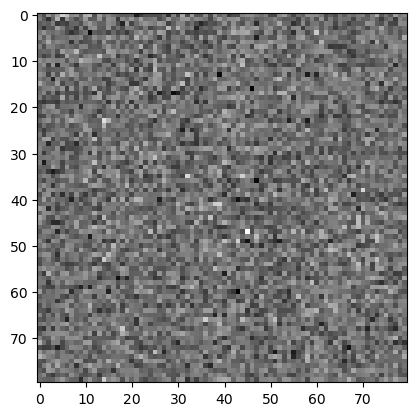

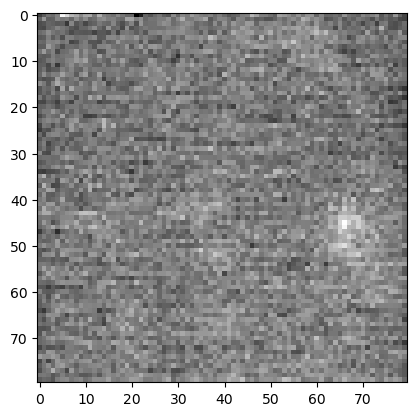

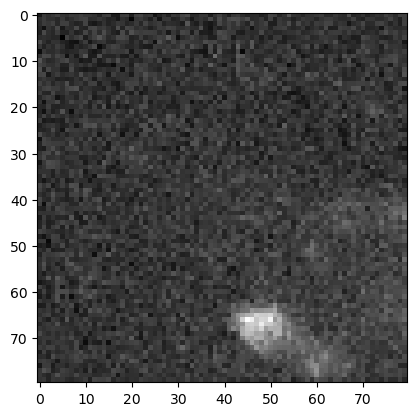

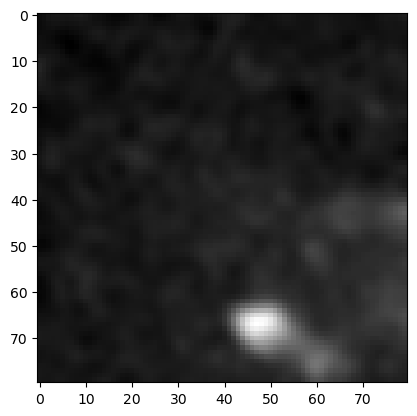

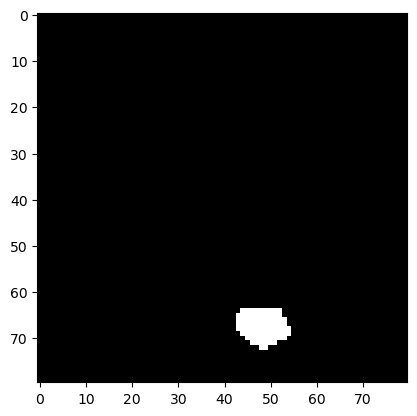

In [347]:
# Visualize one frame for full processing steps
frame_num = 1600 # 1447 or frame_num

plt.imshow(test[dF_var][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

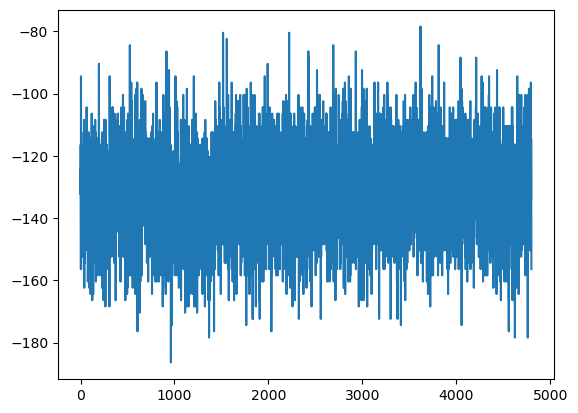

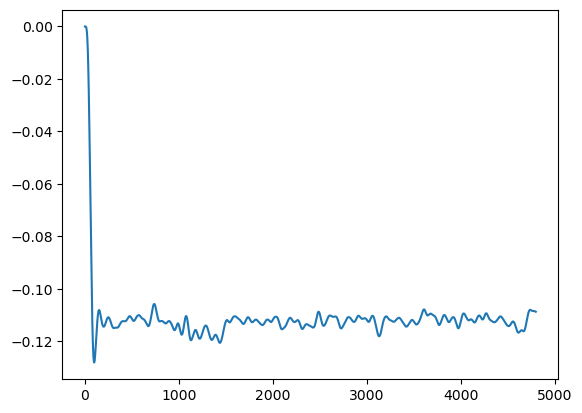

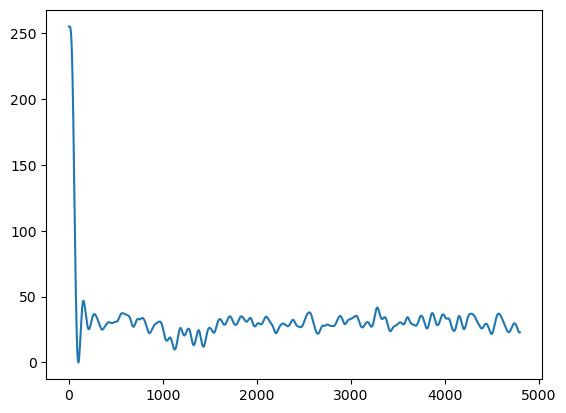

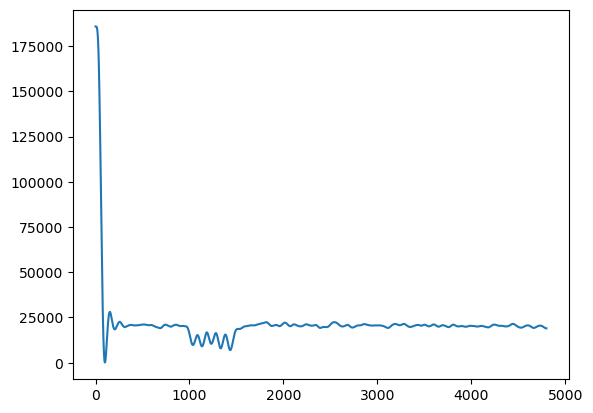

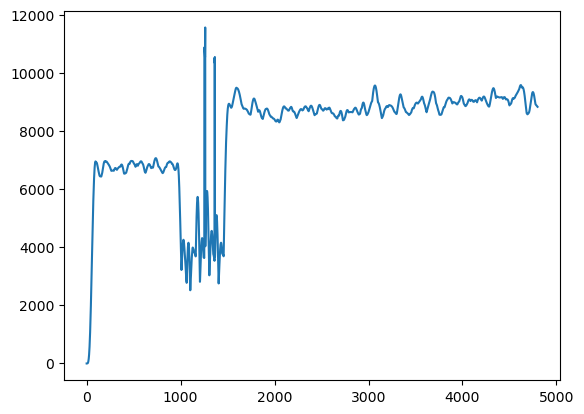

In [348]:
x_coord, y_coord = 20, 60 # 65, 50

plt.plot(range(test[dF_var].shape[-1]-200), test[dF_var][x_coord, y_coord, 100:4900])
plt.show()

plt.plot(range(temp_data.shape[-1]), temp_data[x_coord, y_coord, :])
plt.show()

plt.plot(range(space_data1.shape[0]), space_data1[:, x_coord, y_coord])
plt.show()

plt.plot(range(space_data2.shape[0]), space_data2[:, x_coord, y_coord])
plt.show()

plt.plot(range(space_data3.shape[0]), space_data3[:, x_coord, y_coord])
plt.show()

In [ ]:
plt.plot(range(900, 1600), space_data3[900:1600, 65, 47])
plt.show()

plt.plot(range(900, 1600), np.gradient(space_data3[900:1600, 65, 47]))
plt.show()

plt.plot(range(900, 1600), space_data3[900:1600, 70, 70])
plt.show()

plt.plot(range(900, 1600), np.gradient(space_data3[900:1600, 70, 70]))
plt.show()

In [ ]:
for frame_num in range(0, space_data2.shape[0], 10):
    plt.imshow(space_data2[frame_num, :, :], cmap='gray') # matplotlib.colors.ListedColormap(colors))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{frame_num+100}')
    plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Frames_data240\\{frame_num+100}.png')
    plt.show()

In [ ]:
colors = ['#1a0119', '#008cfd', '#3dff00', '#ff1203']

matplotlib.colors.ListedColormap(colors)

In [ ]:
mask = np.zeros(space_data3.shape)
for x_coord in tqdm(range(space_data3.shape[1])):
    for y_coord in range(space_data3.shape[-1]):
        for frame_num in range(1000, 1500, 5):

            baseline = np.mean(space_data3[100:900, x_coord, y_coord])
            threshold_d = 5000
            signal_pnt = space_data3[frame_num, x_coord, y_coord]

            # Detect depolarization
            if (baseline - threshold_d > signal_pnt):
                mask[frame_num, x_coord, y_coord] = 255.

In [ ]:
for frame_num in tqdm(range(1000, 1500, 5)):
    unique, counts = np.unique(mask[frame_num, :, :], return_counts=True)
    d = dict(zip(unique, counts))
    if (unique.shape[0] > 1) and dict(zip(unique, counts))[255.] > 5:
        fig, ax = plt.subplots(1)
        ax.imshow(img_data[:, :], cmap='gray')
        ax.imshow(mask[frame_num, :, :], cmap=matplotlib.colors.ListedColormap(['#ffffff', '#008cfd']), alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(f'Frame {frame_num+100}')
        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Results\\{frame_num+100}.png')

In [ ]:
mask = np.zeros(space_data3.shape)
for x_coord in tqdm(range(space_data3.shape[1])):
    for y_coord in range(space_data3.shape[-1]):
        for frame_num in range(1500, 2000, 5):

            baseline = np.mean(space_data3[100:900, x_coord, y_coord])
            threshold_h = 5000
            signal_pnt = space_data3[frame_num, x_coord, y_coord]

            # Detect hyperpolarization
            if (baseline + threshold_h < signal_pnt):
                mask[frame_num, x_coord, y_coord] = 255.

In [ ]:
for frame_num in tqdm(range(1500, 2000, 5)):
    unique, counts = np.unique(mask[frame_num, :, :], return_counts=True)
    d = dict(zip(unique, counts))
    if (unique.shape[0] > 1) and dict(zip(unique, counts))[255.] > 5:
        fig, ax = plt.subplots(1)
        ax.imshow(img_data[:, :], cmap='gray')
        ax.imshow(mask[frame_num, :, :], cmap=matplotlib.colors.ListedColormap(['#ffffff', '#ff1203']), alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(f'Frame {frame_num+100}')
        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Results\\{frame_num+100}.png')

In [ ]:
plt.imshow(mask[1675, :, :])
plt.show()
plt.imshow(skimage.measure.block_reduce(mask[1675, :, :], (3, 3), np.mean), cmap='gray')
plt.show()